<a href="https://colab.research.google.com/github/anthonyjalkh/anthonyjalkh.github.io/blob/main/DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# -*- coding: utf-8 -*-
"""
@author: Théo Lebeau, Pierre Guiot, Cateline Lantz, Lucie Degott,Laura Nardelli, Hervé Dole
"""

'\n@author: Théo Lebeau, Pierre Guiot, Cateline Lantz, Lucie Degott,Laura Nardelli, Hervé Dole\n'

In [83]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q ipympl
from google.colab import output
output.enable_custom_widget_manager()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import glob
from astropy.io import fits # Pour ouvrir et manipuler les données
from scipy.ndimage import rotate # Pour la rotation des images
from scipy.optimize import curve_fit # Pour la régression linéaire


# Définition de quelques fonctions utiles de manipulation des images (le détail de leur fonctionnement ne fait pas partie du DM, cette cellule est à part)

In [85]:
#Fonctions importées de la librairie CASTOR (créée pour la coupole d'Orsay par Gabriel Pelouze)

from copy import deepcopy
from tqdm import tqdm
from scipy.signal import fftconvolve

def align_images(Img, img_ref=0, xaxis=True, yaxis=True,
                 gauss=True, sigma=0.5):
    '''Align a series of image relatively to the img_ref,
    along the x and y-axis.
    Parmeters
    =========
    Img : 3D ndarray
        The array of 2D spectra (images) to align.
    img_ref : int (default: 0)
        The index of the image taken as a reference.
    xaxis : bool (default: True)
        Enable x-axis alignment.
    yaxis : bool (default: True)
        Enable y-axis alignment.
    gauss : bool (default: True)
        If True, the images are convolve with a 2D gaussian
        to reduce the effects of sharpy edges.
    sigma : float (default : 0.5)
        If gauss=True, the standard deviation of the use gaussian.
    Returns
    =======
    Img_align : 3D ndarray
        The aligned array of 2D spectra.
    '''
    N, Ysize, Xsize = Img.shape
    Img2 = deepcopy(Img)
    # Gaussian convolution
    if gauss:
        X, Y = np.linspace(-1, 1, Xsize), np.linspace(-1, 1, Ysize)
        G = gauss2d(X, Y, 1, 0, 0, sigma, sigma)
        for i in range(N):
            Img2 *= G
    # Shift determination using FFT convolution
    ref = Img2[img_ref]
    x_dith, y_dith = np.zeros(N, dtype=int), np.zeros(N, dtype=int)
    for i in tqdm(range(N)):
        x_dith[i], y_dith[i] = cross_correlation(ref, Img2[i])
    if not xaxis:
        x_dith[:] = 0
    if not yaxis:
        y_dith[:] = 0
    # Creation of a new set of images, with new dimensions
    x0 = np.max(np.abs(x_dith))
    y0 = np.max(np.abs(y_dith))
    Xnew = Xsize + 2*x0
    Ynew = Ysize + 2*y0
    Img_align = np.zeros((N, Ynew, Xnew))
    # Alignement
    for i in range(N):
        Img_align[i, y0+y_dith[i]:y0+Ysize+y_dith[i], x0+x_dith[i]:x0+Xsize+x_dith[i]] = Img[i]
    # Output
    return Img_align



def gauss2d(x, y, a, x0, y0, sigmax, sigmay):
    '''Compute a 2D gaussian on a grid generated from the
    input x and y arrays.
    G = a * exp( -(x-x0)**2/(2*sigmax**2) - (y-y0)**2/(2*sigmay**2) )
    Parameters
    ==========
    x : 1D ndarray
        The x-axis values.
    y : 1D ndarray
        The y-axis values.
    a : float
        The amplitude of the gaussian.
    x0 : float
        The x-coordinate of the gaussian center.
    y0 : float
        The y-coordinate of the gaussian center.
    sigmax : float
        The standard deviation along the x-axis.
    sigmay : float
        The standard deviation along the y-axis.
    Returns
    =======
    G : 2D ndarray
        The 2D gaussian computed of the (x, y) grid.
    '''
    X, Y = np.meshgrid(x, y)
    G = a * np.exp( -(X-x0)**2/(2*sigmax**2) - (Y-y0)**2/(2*sigmay**2) )
    return G

def cross_correlation(img1, img2):
    '''Determine the shift along the x and y axis between the two input
    2D images, using a 2D FFT convolution.
    Parameters
    ==========
    img1 : 2D ndarray
        The reference 2D spectrum.
    img2 : 2D ndarray
        The 2D spectrum to align
    Returns
    =======
    x_dith : int
        The shift along the x-axis in pixels.
    y_dith : int
        The shift along the y-axis in pixels.
    '''
    ysize, xsize = img1.shape
    corr = fftconvolve(img1, img2[::-1, ::-1], mode='same')
    y_dith, x_dith = np.where(corr == np.max(corr))
    x_dith = int(x_dith) - xsize//2
    y_dith = int(y_dith) - ysize//2
    return x_dith, y_dith

# Lecture des données

Les prochaines lignes permettent d'accéder aux images de science, de Dark, de calib et potentiellement de Flats, pour les lire et récupérer les données sous forme d'array numpy.

Les chemins doivent prendre la forme `chemin/vers/les/fichiers/*`, l'astérique servant à signifier que vous récupérez tous les fichiers à l'intérieur du dossier qui vous intéresse.

**Vous pouvez copier le chemin vers vos données depuis le menu déroulant sur la gauche en cliquant sur les 3 points veritcaux à la droite de votre dossier. Les fichiers que vous avez copiés sur votre Google Drive sont dans le répertoire /content/drive/MyDrive/Colab Notebooks**

Dans la cellule ci-dessous, vous pourrez trouver trois boucles `for` (une pour chaque type de donnée, quatre si vous utilisez le flat), ainsi que des tableaux `XXX_cube`:

* Les boucles `for` parcourent tous les fichiers présents dans le chemin fourni, en les triant dans l'ordre alphanumérique, et en fournissant une variable "compteur" et une variable "nom de fichier" à la boucle `for`.
* Les tableaux `XXX_cube` contiennent 3 dimensions selon lesquelles sont stockées les données : (n,l,c) où n est le numéro de l'image dans la série d'acquisitions, l la dimension des lignes de l'image et c la dimension des colonnes de l'image.

In [86]:
science_path = "/content/drive/MyDrive/Colab Notebooks/DM/beta_aurigae/sci/*" # Chemin vers les données de science # completer les ...
dark_path = "/content/drive/MyDrive/Colab Notebooks/DM/beta_aurigae/dark/*" # Chemin vers les dark
flat_path = "/content/drive/MyDrive/Colab Notebooks/DM/beta_aurigae/flat/*" # Chemin vers les flats
calib_path = "/content/drive/MyDrive/Colab Notebooks/DM/beta_aurigae/calib/*" # Chemin vers les calib

science_cube = []
dark_cube = []
flat_cube = []
dark_flat_cube = []
calib_cube = []

for i, file in enumerate(sorted(glob.glob(science_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    science_cube.append(image)

science_cube = np.asarray(science_cube, dtype=np.float64)

for i, file in enumerate(sorted(glob.glob(dark_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    dark_cube.append(image)

dark_cube = np.asarray(dark_cube, dtype=np.float64)

for i, file in enumerate(sorted(glob.glob(flat_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    flat_cube.append(image)

flat_cube = np.asarray(flat_cube, dtype=np.float64)

for i, file in enumerate(sorted(glob.glob(calib_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    calib_cube.append(image)

calib_cube = np.asarray(calib_cube, dtype=np.float64)

### Visualisation

Afin d'améliorer la visualisation des contrastes des images, vous pourrez spécifier des mots-clef `vmin` et `vmax` à l'intérieur des `plt.imshow()`.
Sans spécifier ces seuils vous risquez de vous retrouver avec des images entièrement blanches, noires, ou saturées.

---
# ❗❗❗❗❗❗❗❗

# ** ❗ Remarque Importante lors de la correction :❗**

1) La cellule suivant contenant la figure 1 doit être exécutée individuellement, sinon elle affiche une image complètement blanche (si on fait "run all", par exemple) et ce malgré avoir essayé toutes les valeurs de vmin et vmax les plus plausibles à résoudre le problème



2) En outre, j'ai transformer la fonction "plt.show()" en commentaire dans mon code vu que les graphes apparaissaient 2 fois. Si aucun graphe n'apparait sur un autre ordinateur, il suffirait d'enlever les "#" qui précèdent les "plt.show()" pour chaque graphe



3) De plus, j'ai écrit les titres qu'on devait modifier nous-mêmes en anglais vu que les "labels" des axes étaient en anglais


# ❗❗❗❗❗❗❗❗
---

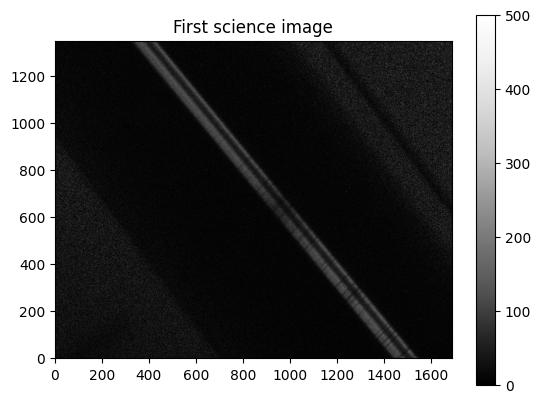

In [116]:
#%matplotlib ipympl

plt.figure(1)
plt.clf()
plt.imshow(science_cube[0], interpolation=None, origin='lower', cmap='Greys_r' ,vmin = 0, vmax = 500)
plt.title('First science image')
plt.colorbar()
#plt.show()

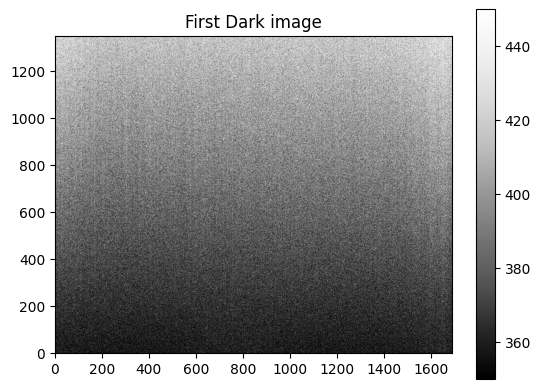

In [88]:
#%matplotlib ipympl

plt.figure(2)
plt.clf()
# Vu qu'il est plus difficile d'arriver à vmin et vmax par tâtonnement pour cette image là, je vais utiliser la ligne de code dans la cellule suivante afin d'essayer des valeurs de vmin et vmax se trouvant autour des valeurs significatives s'une boîte à moustache. Vu que les valeurs minimales et maximales sont très éloignées l'une
# de l'autre, je vais prendere des valeurs de vmin et vmax se trouvant aux alentours de la moyenne et de la médiane (ces deux dernières prenant des valeurs extrêmement proches l'une de l'autre )
plt.imshow(dark_cube[0], interpolation=None, origin='lower', cmap='Greys_r' ,vmin = 350, vmax = 450)
plt.title('First Dark image')
plt.colorbar()
#plt.show()

In [89]:
print(np.min(dark_cube))
print(np.max(dark_cube))
print(np.mean(dark_cube))
print(np.median(dark_cube))

237.0
65535.0
391.0195744163662
387.0


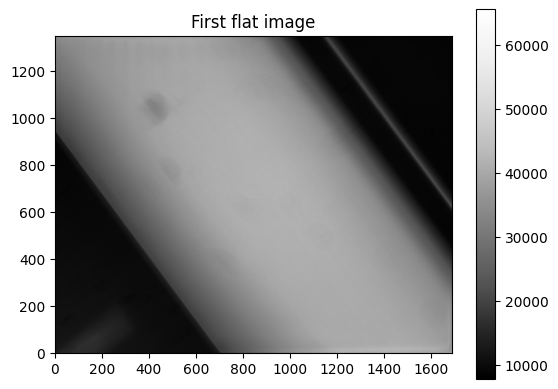

In [90]:
#%matplotlib ipympl

plt.figure(3)
plt.clf()
plt.imshow(flat_cube[0], interpolation=None, origin='lower', cmap='Greys_r')
plt.title('First flat image')
plt.colorbar()
#plt.show()

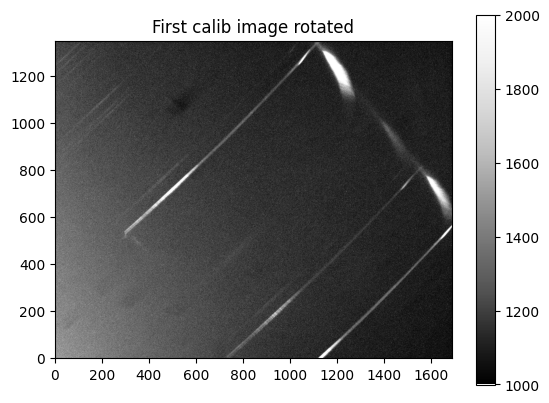

In [91]:
#Affichage de l'image de calib

plt.figure(4)
plt.clf()
plt.imshow(calib_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys_r', vmin = 1000,  vmax = 2000 )
plt.title('First calib image rotated')
plt.colorbar()
#plt.show()

# Réduction des données

Dans cette section, le but est de réduire les données brutes de science, pour parvenir à des données exploitables scientifiquement.

Une image dite réduite, $I_{corr}$ ici, est l'image brute, $I_{brute}$, à laquelle on soustrait d'abord la moyenne (temporelle) des images de dark, $<I_{Dark}>$, qu'on nomme aussi master dark.

Quand les images de flat sont de qualtié suffisante, c'est qui est le cas pour ce DM, on divise le résultat de la soustraction par la moyenne (temporelle) des images de flat, $<I_{flat}>$.

On l'appelle master flat: $MF=<I_{flat}>$


Et on normalise en divisant par la moyenne sur les pixels (donc spatiale cette fois) du master flat : $\overline{MF}$.

La formule complète, que vous pouver retrouver en annexe A.3 du poly de TP,   est donc la suivante :

 $I_{corr}=\frac{I_{brute}-<I_{Dark}>}{MF/\overline{MF}}$

 Les cellules ci-dessous sont la traduction de ces équations

### *Question: A quoi servent le dark et le flat ?*

## *Réponses : (double-cliquez pour modifier le texte)*

1) D'après le poly de TP, le dark, qui est une image prise sans lumière, nous permet de corriger les biais additifs systématiques et les biais thermiques vu que même s'il fait complètement noir, il reste des électrons. Soustraire le dark nous permet d'enlever le signal thermique et les erreurs dues à la présence de ces derniers

2) D'après le poly de TP, le flat, qui, lui, est une image prise lors d'une illumination homogène, nous permet de corriger les biais multiplificatifs d'inhomogénéité spatiale. En effet, certains pixels sont plus sensibles que d'autres. Divisé par le flat normalisé nous permet d'avoir une sorte de sensibilité homogène pour tous les pixels

In [92]:
master_dark = np.mean(dark_cube, axis=0) #Le master dark, c'est une image

for i in range(science_cube.shape[0]):
    science_cube[i,:,:] = science_cube[i,:,:] - master_dark #On soustrait le master dark aux images brutes

master_flat = np.mean(flat_cube , axis=0) #Le master flat, c'est une image

spatial_mean=np.mean(master_flat) #La moyenne spatiale du master flat, c'est l'intensité moyenne sur les pixels c'est donc un nombre.

normalized_master_flat = master_flat/spatial_mean #On divise le master flat par sa valeur moyenne pour normaliser l'intensité, c'est une image

for i in range(science_cube.shape[0]):
    science_cube[i,:,:] = science_cube[i,:,:]/normalized_master_flat #C'est la deuxième partie de l'équation de l'énoncé, on l'utilise quand nos données de flat sont de qualité.
    # Remplacer les NaN par 0 après la division
    science_cube[i, :, :] = np.nan_to_num(science_cube[i, :, :], nan=0.0, posinf=0.0, neginf=0.0)
    #science_cube est une liste d'image, désormais réduites

### Visualisation

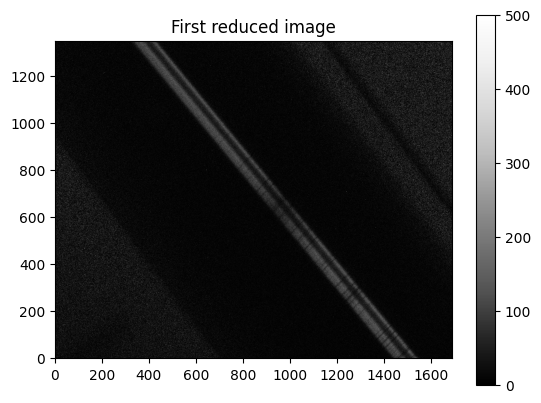

In [115]:
#%matplotlib ipympl

plt.figure(5)
plt.clf()
plt.imshow(science_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys_r',vmin = 0 , vmax = 500)
# Essayer de modifier le premier indice du cube pour tester.
plt.title('First reduced image')
plt.colorbar()
#plt.show()

# Rotation des spectres

Le plus souvent, les spectres que vous obtiendrez en sortie de la réduction seront inclinés. Etant donné que votre but sera d'analyser des spectres, cela sera plus simple s'il suffit de récupérer une ligne dans un tableau numpy pour faire ce travail. Il faudra donc faire tourner l'image selon un angle que vous aurez déterminé pour que le spectre soit horizontal.

Pour pouvoir étalonner facilement les spectres, il faut faire cette démarche avec l'image de calibration également.

L'angle optimal de rotation peut être déterminé à l'aide de DS9. Attention l'angle optimal pour la rotation par python est l'opposé de l'angle donné par DS9 $\theta_{opt, python} = - \theta_{opt, DS9}$

## *Questions:*
1 - Quelles sont les dimensions de l'image ?

2 - Pourquoi a-t-on besoin de tourner l'image pour extraire un spectre ?



In [111]:
# Le seul but de cette cellule est de me permettre de répondre à la question 1 se trouvant dans la cellule précédente
print(science_cube.shape)

(2, 1351, 1689)



## *Réponses : (double-cliquez pour modifier le texte)*


---

### Réponse à la première question :

1) Comme chaque cellule du tableau numpy représente un pixel de l'image qui lui est associée, Les dimensions de cette dernière peuvent être obtenues en regardant les dimensions du tableau numpy qui lui correspond et ceci en utilisant la commande python ".shape" sur le tableau science_cube (vu qu'il s'agit du tableau associé à l'image en question) comme le montre la cellule précédente. La réponse obtenue est : 1351x1689 px

    En effet, le premier élément du tuple imprimé dans la cellule précédente représente le nombre d'images dans le fichier "sci" (On peut confirmer qu'il y en a uniquement 2 en accédant manuellement au fichier "sci" --> On voit bien qu'il y a juste 2 images) alors que le deuxième et le troisième éléments représentent le nombre de lignes et de colonnes respectivement. Le nombre de cellules étant simultanément égal au nombre de pixels ainsi qu'au nombre de lignes multiplié par le nombre de colonnes nous permet de déterminer que les dimensions de l'image sont bel et bien 1351x1689 pixels.



### Réponse à la seconde question :

2) À cause de plusieurs contraintes expérimentales couplées à l'effet Doppler généré par la rotation, mais aussi aux imprécisions expérimentales tel que le fait que le détecteur ne soit pas solidaire du spectromètre, les spectres se retrouvent orientés suivant un angle non-optimal. Vu que certains détecteurs sont généralement plus précis au centre et afin de mieux interpréter les résultats à l'aide de l'axe des abscisses, on tourne l'image afin qu'elle soit horizontale et donc alignée avec ce dernier.

    En outre, la raison principale qui nous pousse à tourner l'image afin d'extraire un spectre est qu'il est plus simple d'utiliser une ligne dans le tableau numpy. En effet, si le spectre n'est pas horizontal, il affectera des cellules situées sur d'autres lignes falsifiant ainsi les données. Le rendre horizontal nous permet de tout lire sur une seule ligne sans en affecter d'autres



In [95]:
### Données de science ###

rotated_cube =[]
rotation_angle = -50.5 # Angle en degrés à déterminer à l'aide de DS9 pour mettre le spectre horizontal, remplacer le 1.
for i in range(science_cube.shape[0]):
    rotated_cube.append(rotate(science_cube[i,:,:], rotation_angle))
rotated_cube = np.asarray(rotated_cube)

### Visualisation

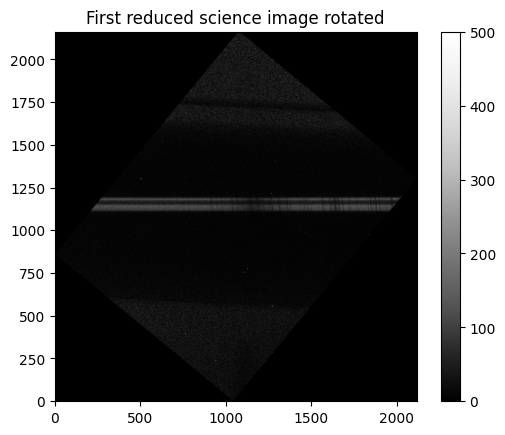

In [114]:
#%matplotlib ipympl

### Données de science ###

plt.figure(6)
plt.clf()
plt.imshow(rotated_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys_r',vmin= 0, vmax=500)
plt.title('First reduced science image rotated')
plt.colorbar()

#plt.show()

# Augmentation du rapport signal sur bruit: alignement des images avant stacking

Lors de l'acquisition de données, notre but est de recueillir le plus de signal possible de l'objet à étudier. On mesure la qualité de l'acquisition avec le rapport signal sur bruit ( SNR : Signal to Noise Ratio, voir section 3.1 du poly de TP), c'est-à-dire le ratio de tous les électrons captés sur les électrons associés au bruit.

Par définition, si on a N électrons, on aura $\sqrt N$ électrons (voir l'annexe 1.3 du poly) de bruit donc on a $SNR=\frac{N}{\sqrt N} ∝ \sqrt N$. Le nombre d'électrons détectés étant proportionnel au temps d'exposition, plus le temps d'exposition sera long, plus le signal scientifique ressortira du bruit. Mais le temps d'acquisition unitaire étant limité (cf. poly de TP), il est également utile d'acquérir plusieurs images au même temps de pose puis de les sommer pour faire augmenter le SNR. Le problème est que la source va légèrement se déplacer sur l'image au cours du temps, il est donc nécessaire d'aligner les images entre elles avant de les sommer, ce que fait la ligne de code ci-dessous.


In [97]:
aligned_rotated_cube=align_images(rotated_cube)

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipython-input-1445930204.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_dith = int(x_dith) - xsize//2
/tmp/ipython-input-1445930204.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_dith = int(y_dith) - ysize//2
100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


# Définition de la zone du spectre

On va ensuite chercher la zone contenant le signal significatif du spectre  dans les spectres alignés. Pour cela on effectue une coupe verticale (dimension spatiale de l'image, perpendiculaire au spectre) dans l'image, on repère la zone d'intérêt et les zones qui ne sont que du bruit. Un critère quantitatif permettant de déterminer ces limites pourrait être l'écart-type.

Afin d'augmenter encore le SNR on va également moyenner le signal dans chaque image sur quelques lignes dans la zone d'intérêt.

 **Attention** pour les sujets portant sur des objets spatialement résolus (ex: Lune, Géantes), la dimension spatiale du spectre contient aussi une information, il ne faut donc pas moyenner les lignes. Ce n'est pas le cas pour le DM (les étoiles sont des objets non-résolus avec notre matériel, ormis le Soleil évidemment)

 PS : pour cette partie (et seulement pour le DM) les bonnes données ont déjà été triés dans vos fichiers, donc on peut simplement regarder la première image du cube après rotation.

## Réponse: *(double-cliquez pour modifier le texte)*

* * *

### Réponse à la première question :

1.  La Figure 8, générée par la cellule de code `FzXbWI__WQkQ`, présente une "coupe verticale" de la première image science réduite, alignée et tournée (`aligned_rotated_cube[0,:,:]`). Plus précisément, elle trace l'intensité des pixels (axe des ordonnées) en fonction de l'indice de la ligne (axe des abscisses) pour une colonne spécifique (la colonne 1200, telle que définie dans le code `plt.plot(aligned_rotated_cube[0][:,1200])`). Le but de cette visualisation est d'examiner la distribution spatiale du signal le long de la dimension perpendiculaire à la dispersion du spectre.

    Pour choisir la ligne(s) de pixel pour extraire le spectre, on analyse cette coupe verticale de la manière suivante :

    *   **Identification de la zone de signal :** On observe une région sur l'axe des abscisses (indices de ligne) où l'intensité des pixels (axe des ordonnées) est significativement plus élevée que dans les régions environnantes. Cette région de haute intensité correspond à l'emplacement spatial du spectre de l'objet observé sur le détecteur. Les régions où l'intensité est faible et présente des fluctuations aléatoires correspondent principalement au bruit de fond (incluant le bruit de lecture, le courant d'obscurité résiduel après soustraction du *master dark*, et potentiellement la lumière du ciel si non complètement soustraite ou si les *flats* ne sont pas parfaits).
    *   **Localisation du centre du spectre :** Au sein de cette zone de signal, l'intensité atteint généralement un pic ou un plateau plus ou moins plat. Le sommet de ce pic ou le milieu de ce plateau indique l'emplacement spatial central du spectre sur le détecteur pour cette colonne donnée.
    *   **Choix de la(les) ligne(s) pour l'extraction :**
        *   Si l'objectif est d'extraire un spectre 1D à partir d'une *seule* ligne, on choisit l'indice de ligne (valeur sur l'axe des abscisses) qui correspond au pic maximum d'intensité dans la zone de signal identifiée. Cette ligne est censée capturer le signal le plus fort de la source astronomique. Dans votre cas, en observant la Figure 8, la zone de signal s'étend approximativement des lignes 200 à 2100. Le pic d'intensité semble se situer autour de l'indice de ligne `1130`, qui est d'ailleurs la valeur choisie pour `central_pix` et `average_pixels` dans la cellule `VoWNYjr4Ylhn`.
        *   Dans le contexte de ce DM, pour augmenter le rapport signal sur bruit (SNR) en moyennant le signal sur la dimension spatiale (ce qui est approprié pour une source ponctuelle comme une étoile), on choisit une *plage* de lignes centrée sur la zone de signal identifiée. La valeur de `average_pixels = 1130` est choisie comme le centre de cette plage, et la moyenne est effectuée sur 40 lignes (`average_pixels-20` à `average_pixels+20`, soit de 1110 à 1149 inclus). Cette plage est sélectionnée pour englober la majorité du signal tout en minimisant l'inclusion de régions dominées par le bruit.

    En résumé, la coupe verticale (Figure 8) sert de profil spatial du spectre dans une colonne donnée. En identifiant la région d'intensité élevée qui se distingue du bruit de fond, on détermine l'emplacement du spectre et on choisit la ligne (pour une extraction sur une seule ligne) ou la plage de lignes (pour une extraction moyennée) qui maximise la capture du signal tout en étant centrée sur la source. La plage de 200 à 2100 que vous avez identifiée est une observation correcte de l'étendue spatiale générale de la *zone où le signal est présent*, et `1130` représente l'indice de ligne central où le signal est le plus fort dans cette coupe spécifique.

### Réponse à la seconde question :

2.  Bien que l'axe des abscisses du graphe (Figure 8) représente le numéro de la ligne spatiale sur le détecteur, la direction horizontale des images (c'est-à-dire l'axe des colonnes) représente la dimension de la **longueur d'onde**. Le spectrographe disperse la lumière de l'objet observé, envoyant différentes longueurs d'onde vers différentes positions horizontales sur le détecteur. Ainsi, à mesure que l'on se déplace horizontalement le long d'une ligne du spectre, on observe l'intensité du signal à des longueurs d'onde différentes. La calibration ultérieure (cellules `iKLfs3eaopSQ` à `t9fgy9-xBR6Y`) permet de convertir cet axe des colonnes (indices de tableau) en un axe des longueurs d'onde calibrées (en unités physiques comme les nanomètres).

Text(0.5, 1.0, 'Vertical cut at column 800')

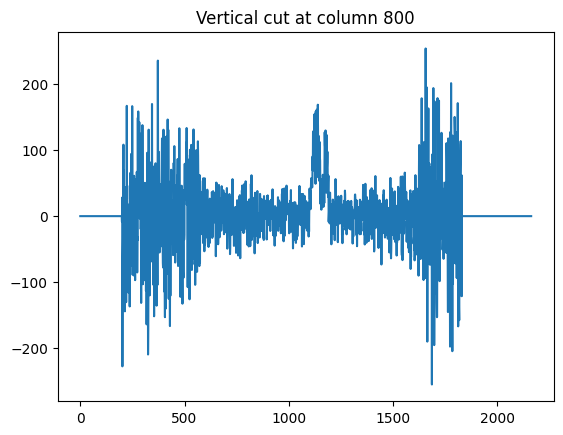

In [98]:
plt.figure(8)
plt.clf()
plt.plot(aligned_rotated_cube[0][:,800]) #Indiquez la ligne que vous voulez voir (remplacer le 1)
plt.title('Vertical cut at column 800')
#plt.show()

In [99]:
cut = aligned_rotated_cube[0][:,800] # Changed from 1200 to 800

# Calculate the Median Absolute Deviation (MAD) as a robust noise estimate
# MAD is less sensitive to outliers than standard deviation
mad = np.median(np.abs(cut - np.median(cut)))

sigma_noise = mad * 1.4826 # Convert MAD to equivalent standard deviation for Gaussian noise
print(sigma_noise)

threshold = 3 * sigma_noise

signal_indices = np.where((cut - np.median(cut)) > threshold)[0] #signal_indices = np.where(np.abs(cut) > threshold)[0]

# Check if any signal pixels were found before trying to access indices
if len(signal_indices) > 0:
    start, end = signal_indices[0], signal_indices[-1]
    print("Signal region indices:", start, end)
else:
    print("No signal found above the threshold.")
    # You might want to adjust the threshold or handle this case appropriately
    start, end = None, None # Or set to default values if needed

21.639594611439556
Signal region indices: 207 1824


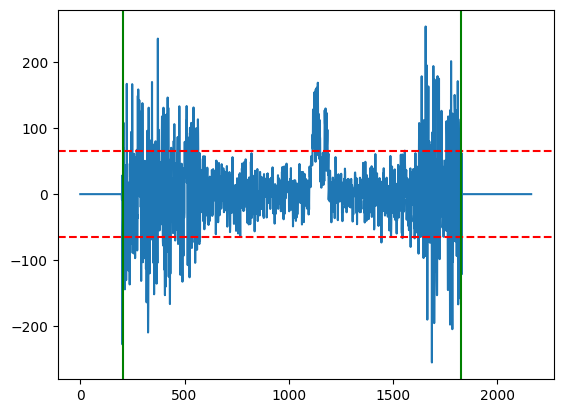

In [100]:
plt.plot(cut)
plt.axhline(threshold, color='red', linestyle='--')
plt.axhline(-threshold, color='red', linestyle='--')
plt.axvline(start, color='green')
plt.axvline(end, color='green')
plt.show()

## *Questions :*
1- En utilisant la coupe verticale, expliquer comment vous choisissez la ligne de pixel pour extraire le spectre.

2- Quel paramètre physique varie selon la direction horizontale des images ?

## Réponse: *(double-cliquez pour modifier le texte)*

### Réponse à la question 1:

Vu que l'axe des abscisses du graphe représente le numéro de la ligne, alors que l'axe des ordonnées représente leur intensité correspondante à la colonne 800, on pourrait visuellement croire que le spectre s'étend sur les lignes de la colonne 800 se caractérisant par des intensités bien plus élevées que les autres lignes et donc de la ligne 200-300 à la ligne 2100. Cependant, la méthode de l'écart moyen absolu montre que ceci est une décision assez prémature. J'ai décidé d'utiliser cette meethode au lieu de l'écart-type vu que, comme ce dernier représente une distance par rapport à une moyenne, il est bien plus sensible aux valeurs aberrantes que l'écart moyen absolu qui, lui, est étroitement lié à la notion de distance par rapport à la médiane. Afin d'écrire le code relatif à cette section, j'ai faire quelques recherches pour la formule relative à l'écart moyen absolu ainsi que pour trouver le facteur de conversion 1.4826. J'ai également utiliser internet afin de m'assurer du fait qu'il s'agit d'une méthode valide dans notre contexte et afin de m'aider à corriger quelques erreurs dans le code. En outre, j'ai utiliser la convention 3*sigma afin de définir le seuil. On peut alors, à présent, utiliser le nouveau graphe obtenu afin de visiuellement distinguer le signal du bruit. Il faut cependant veiller à se rappeler que ce qui nous intéresse vraiment est le signal positif.

--

### Réponse à la question 2:

Bien que l'axe des abscisses du graphe représente le numéro de la ligne, la direction horizontale des images, elle, représente la longueur d'onde mesurée.

# Extraction du spectre 1D et moyenne sur les lignes


Afin d'augmenter encore le SNR on va également moyenner le signal dans chaque image sur quelques lignes dans la zone d'intérêt.

 **Attention** pour les sujets portant sur des objets résolus (ex: Lune, Géantes), la dimension spatiale du spectre contient aussi une information, il ne faut donc pas moyenner les lignes. Ce n'est pas le cas pour le DM (les étoiles sont des objets non-résolus avec notre matériel, ormis le Soleil évidemment)

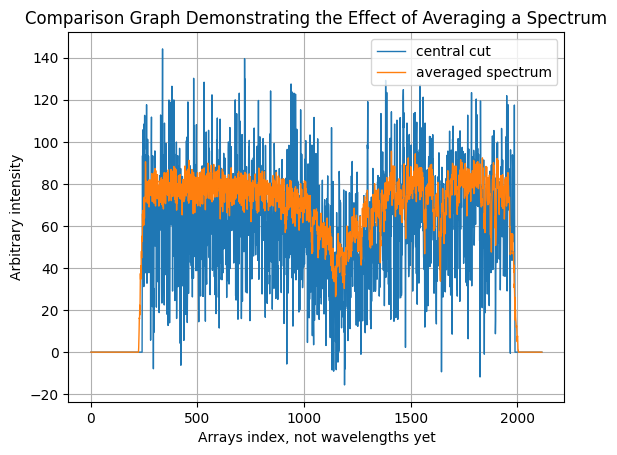

In [101]:
#%matplotlib ipympl

average_pixels= 1150# Pixel central autour duquel les 20 pixels voisins sont moyennés pour "lisser" le spectre extrait.

avg_spectrum=[]
#======================================================================================================
# À ne faire que si la dimension spatiale de vos données n'a pas d'importance ! Sinon, ne pas moyenner.
for i in range(len(aligned_rotated_cube[:,0,0])):
  extract_avg_spectrum= np.mean(aligned_rotated_cube[i,average_pixels-20:average_pixels+20,:], axis=0)
  avg_spectrum.append(extract_avg_spectrum)
avg_spectrum=np.array(avg_spectrum)
#======================================================================================================

central_pix= 1150 # Pixel central où le spectre 1D est extrait (sans moyenne). À modifier


plt.figure(9)
plt.clf()
plt.plot(aligned_rotated_cube[0,central_pix,:], lw=1, label='central cut')
plt.plot(avg_spectrum[0,:], lw=1, label='averaged spectrum')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Arrays index, not wavelengths yet')
plt.title('Comparison Graph Demonstrating the Effect of Averaging a Spectrum') # À modifier
plt.grid()
plt.ylim()
plt.legend(loc='best')
#plt.show()

## *Question: Sur combien de lignes avez-vous moyenné le spectre ? Pourquoi ? Décrivez l'impact de la sommation sur plusieurs lignes observé sur la figure 9*

## *Réponse: (double-cliquez pour modifier le texte)*

*   **Sur combien de lignes avez-vous moyenné le spectre ?**
    Based on the code, the spectrum has been averaged over **40 lines (rows)**. The code selects rows from `average_pixels - 20` (1110) to `average_pixels + 20` (1150), which is a range of 40 rows.

*   **Pourquoi ?**
    Averaging over multiple lines in the spatial direction (perpendicular to the spectrum) is done to **increase the signal-to-noise ratio (SNR)**. By averaging the signal across adjacent rows where the astronomical signal is present, the impact of random noise fluctuations in individual pixels is reduced. Noise tends to cancel out when averaged over multiple samples, while the true signal is preserved, making the spectral features more prominent.

*   **Décrivez l'impact de la sommation sur plusieurs lignes observé sur la figure 9.**
    Figure 9 shows a comparison between the 'central cut' (spectrum from a single line) and the 'averaged spectrum' (spectrum averaged over 40 lines). The impact of averaging is clearly visible:
    *   The **'averaged spectrum' is significantly smoother** than the 'central cut'. The rapid, noisy fluctuations present in the single-line spectrum are greatly reduced.
    *   This **reduction in noise makes the spectral features (peaks and dips) more distinct and easier to identify** in the 'averaged spectrum'. The true signal is more apparent above the background noise.
    *   The **overall shape and the positions of major features** are similar between the two plots, indicating that the averaging process effectively enhanced the signal without distorting the underlying spectral information.

## *Réponse (Version Très Détaillée et Précise):*

Pour effectuer la conversion de l'axe des pixels à celui des longueurs d'onde, une étape cruciale de la réduction de données spectroscopiques, on utilise un spectre de référence provenant d'une lampe de calibration (ici, une lampe Argon-Néon). Le processus de choix des valeurs caractéristiques repose sur l'identification et le mappage précis de raies d'émission connues dans le spectre de cette lampe aux positions correspondantes sur le détecteur (en pixels). Voici une explication détaillée :

1.  **Principe Fondamental :** Le fonctionnement d'un spectrographe repose sur la dispersion de la lumière : différentes longueurs d'onde sont envoyées vers différentes positions sur le détecteur. Pour calibrer cet instrument, il est nécessaire d'établir une relation fonctionnelle (appelée "solution de dispersion") entre la position sur le détecteur (mesurée en pixels le long de la direction de dispersion) et la longueur d'onde correspondante. Une lampe de calibration émet de la lumière à des longueurs d'onde très spécifiques et bien connues, servant ainsi de "règle" spectrale étalonnée.

2.  **Acquisition du Spectre de Calibration :** Un spectre de la lampe de calibration (ici Ar-Ne) est acquis dans les mêmes conditions instrumentales (configuration du spectrographe, focus, température du détecteur, etc.) que les données scientifiques. Ceci est essentiel pour garantir que la solution de dispersion déterminée pour le spectre de calibration s'applique fidèlement aux spectres scientifiques. Les images de calibration sont traitées (soustraction du dark, division par le flat si applicable) et, dans ce cas précis, subissent la même rotation et le même moyennage spatial que les spectres scientifiques pour s'assurer que les positions des raies sont mesurées dans le même système de coordonnées et avec la même amélioration du rapport signal sur bruit (SNR) (voir cellules `NNQxs0IlqdAh` et `AS_otHzfsyJi`). Le spectre 1D moyenné de la lampe Ar-Ne est visualisé dans la Figure 12.

3.  **Identification des Raies d'Émission dans le Spectre Observé (Figure 12) :** L'étape suivante consiste à identifier les pics lumineux distincts dans le spectre 1D de la Figure 12. Ces pics correspondent aux raies d'émission atomique du gaz (Argon et Néon) excité dans la lampe. On se concentre sur les pics les plus intenses et les mieux définis, car ils offrent la meilleure précision pour la détermination de leur position en pixels. Des pics faibles ou bruités sont évités car leur position centrale est moins bien déterminée.

4.  **Consultation d'une Référence Spectrale (TP poly Section 3.5.2) :** Simultanément, on consulte une table de référence des longueurs d'onde des raies d'émission de l'Argon et du Néon (fournie dans la Section 3.5.2 du poly de TP). Cette table liste les longueurs d'onde précises des raies Ar-Ne, souvent accompagnées de leurs intensités relatives. Il est crucial de sélectionner la table correspondant à la résolution spectrale appropriée (haute ou basse résolution, selon le réseau de diffraction utilisé).

5.  **Appariement (Matching) des Pics Observés aux Raies de Référence :** C'est l'étape la plus délicate. Il s'agit d'associer chaque pic identifié dans la Figure 12 à la raie d'émission correspondante dans la table de référence. Ce processus se fait généralement par :
    *   **Reconnaissance de Motifs :** Les raies d'émission Ar-Ne présentent des motifs caractéristiques en termes de longueurs d'onde relatives et d'intensités relatives. On cherche un sous-ensemble de raies dans la table de référence dont le motif (espacement relatif et intensités relatives) correspond au motif des pics observés dans la Figure 12.
    *   **Estimation Grossière de la Plage de Longueurs d'Onde :** Bien que la calibration ne soit pas encore faite, on peut souvent avoir une idée approximative de la plage de longueurs d'onde couverte par l'instrument (par exemple, basée sur les spécifications du spectrographe ou des observations précédentes). Cela permet de restreindre la recherche dans la table de référence aux raies qui sont susceptibles de se trouver dans cette plage.
    *   **Utilisation des Raies les Plus Brillantes :** Les raies les plus intenses dans la table de référence correspondent généralement aux pics les plus hauts dans la Figure 12. Commencer par identifier les raies les plus brillantes dans les deux jeux de données peut aider à initialiser l'appariement.
    *   **Vérification par Cohérence :** Une fois quelques appariements initiaux proposés, on vérifie si d'autres pics observés correspondent aux positions en pixels prédites par une relation linéaire grossière basée sur les appariements initiaux. Si plusieurs raies s'alignent de manière cohérente, l'appariement est probablement correct.

6.  **Extraction des Valeurs Caractéristiques :** Une fois les appariements fiables établis pour plusieurs raies (idéalement plus de deux et réparties sur toute la plage de pixels), on extrait les "valeurs caractéristiques" qui sont :
    *   Les **positions précises en pixels** de ces pics identifiés dans la Figure 12.
    *   Les **longueurs d'onde précises et connues** correspondantes de la table de référence.

7.  **Modélisation de la Solution de Dispersion :** Ces paires de données (position en pixel, longueur d'onde) sont ensuite utilisées pour modéliser la relation entre pixel et longueur d'onde. Pour un spectrographe simple, une relation linéaire (affine) est souvent suffisante : $\lambda = a \times \text{pixel} + b$. Le code dans la cellule `4lzWMEdytXll` utilise la fonction `curve_fit` de SciPy pour déterminer les coefficients `a` et `b` de cette droite qui "fit" au mieux les points (pixels_peaks, peaks_lambda) fournis.

8.  **Application de la Calibration :** Une fois les coefficients `a` et `b` déterminés, la relation affine est appliquée à *tous* les indices de pixels le long de la direction de dispersion pour générer l'array `calib_wavelengths`. Cet array associe désormais une longueur d'onde calibrée à chaque pixel, permettant ainsi de tracer les spectres scientifiques en fonction de la longueur d'onde (comme dans la Figure 13).

En résumé, le choix des valeurs caractéristiques pour la calibration consiste à sélectionner un ensemble de raies d'émission fiables dans le spectre de la lampe de calibration, à mesurer précisément leurs positions en pixels, et à les associer à leurs longueurs d'onde connues issues d'une référence tabulée. Ces paires de données (pixel, longueur d'onde) servent de points d'ancrage pour déterminer la fonction mathématique qui convertit toutes les positions en pixels en longueurs d'onde.

## *Réponse: (double-cliquez pour modifier le texte)*



# Moyenne

On va moyenner les spectres alignés pour augmenter le SNR. Certaines acquisitions sont de mauvaises qualité, il ne faut pas les prendre pour la moyenne (ou sommation). En utilisant la figure 8 ci-dessus, sélectionnez les spectres de bonne qualité en notant leur numéro de fichier (le X à la fin de du fichier 'data_00X.fit' en supposant que les données de science sont classées de 1 à N) dans la liste index.

PS : Dans ce DM les données ont déjà été triées pour ne garder que les bonnes, donc l'index est déjà rempli avec les deux images dont vous disposez.
Ce ne sera pas le cas pour la réduction des données acquissent sous la coupole.

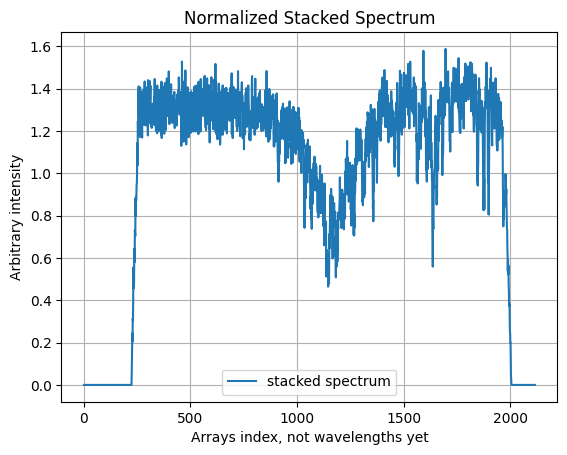

In [102]:
index=np.array([1,2])
index=index-1

for i in range(len(avg_spectrum[:,0])):
  avg_spectrum[i,:]/=np.mean(avg_spectrum[i,:])

stacked_average_spectrum=np.mean(avg_spectrum[index,:], axis=0)


plt.figure(10)
plt.clf()
plt.plot(stacked_average_spectrum,label='stacked spectrum')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Arrays index, not wavelengths yet')
plt.title('Normalized Stacked Spectrum') # À modifier --> En effet, on voit que loop "for" normalise les spectres avant qu'on ne les superpose
plt.grid()
plt.ylim()
plt.legend(loc='best')
#plt.show()

#Calibration

Pour faire l'analyse des résulats il nous faut convertir l'axe des abcisses du spectre de pixel à longueurs d'onde. Pour faire la conversion nous utilisons les données d'un spectre de référence (ici la lampe Argon-Néon dans le spectro). Il faut pour cela identifier la position en pixel de pics caractéristiques dans le spectre Ar-Ne grâce au spectre de référence (en longueur d'onde) en section 3.5.2 du poly de TP. Selon le réseau utilisé pendant la prise de données il faut utiliser le spectre à haute ou basse résolution. Il faut rentrer les valeurs dans les listes ci-dessous afin d'établir la relation affine pixel-$\lambda$.


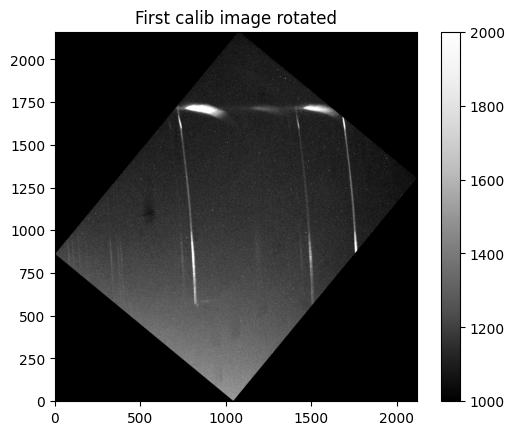

In [103]:
#Affichage de l'image de calib avec rotation

# rotation de la calib avec le meme angle que pour les images de science
rotated_calib=[]
for i in range(calib_cube.shape[0]):
    rotated_calib.append(rotate(calib_cube[i,:,:], rotation_angle))
rotated_calib = np.asarray(rotated_calib)

plt.figure(11)
plt.clf()
plt.imshow(rotated_calib[0,:,:], interpolation=None, origin='lower', cmap='Greys_r', vmin = 1000 ,  vmax = 2000)
plt.title('First calib image rotated')
plt.colorbar()
#plt.show()

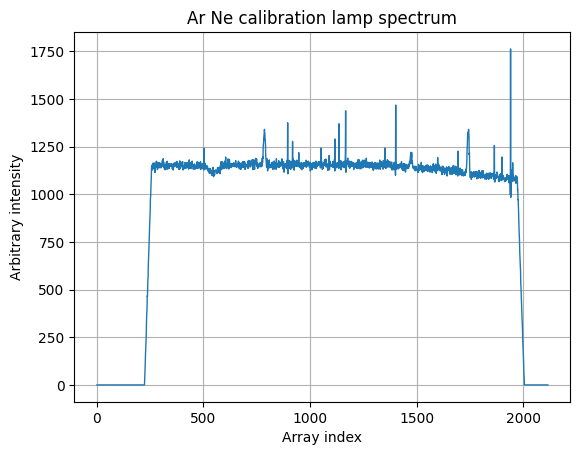

In [104]:
# moyenne sur les mêmes lignes que les images de science
avg_calib = []
for i in range(len(rotated_calib[:,0,0])):
  extract_avg_calib= np.mean(rotated_calib[i,average_pixels-20:average_pixels+20,:], axis=0)
  avg_calib.append(extract_avg_calib)
avg_calib=np.array(avg_calib)

plt.figure(12)
plt.clf()
plt.plot(avg_calib[0,:],lw=1)
plt.xlabel('Array index')
plt.ylabel('Arbitrary intensity')
plt.title('Ar Ne calibration lamp spectrum')

plt.grid()
#plt.show()

In [108]:
#pixels_peaks = np.array([ 50,860  ,890 ]) # A remplir
#peaks_lambda = np.array([  638.3, 640 , 642   ]) # A remplir
pixels_peaks = np.array([1400, 1700, 1950])   # indices à ajuster selon tes mesures exactes
peaks_lambda = np.array([633.4428, 638.2992, 640.2246])
def affine(x, a=1, b=1):
    return a*x + b

calib_wvl = curve_fit(affine, pixels_peaks, peaks_lambda, p0=[2, 50])

calib_wavelengths = affine(range(len(extract_avg_spectrum)), a=calib_wvl[0][0], b=calib_wvl[0][1])

Pics détectés (pixel, hauteur):
0 265 62.52053542652179
1 279 65.25189768312754
2 294 63.73578849453189
3 309 65.25592985227348
4 332 65.42354608009668
5 356 62.4831062089871
6 388 64.03707139984763
7 398 64.8236042540353
8 446 64.01901174935051
9 460 66.53876708094515
10 487 63.17672046691521
11 495 63.561161271284405
12 563 65.61435017024061
13 577 64.43045989464798
14 597 64.93694936312846
15 611 68.78634152892695
16 633 61.51221778911295
17 651 63.16247344678632
18 686 64.98555641933415
19 707 63.267026718274735
20 741 66.23180790238479
21 761 62.36714522190426
22 772 63.18692598568932
23 789 64.2313016846846
24 851 63.35530710907405
25 875 62.6329925973953
26 884 61.432570424536124
27 905 60.516536696572786
28 933 60.791681948133395
29 952 59.16573005472975
30 965 59.87505169835019
31 983 59.743053393728886
32 1045 53.72667634550071
33 1082 47.79007237343116
34 1117 44.13075751423111
35 1160 39.99426189016812
36 1174 38.09343181608847
37 1201 41.78849634195728
38 1229 48.804060813

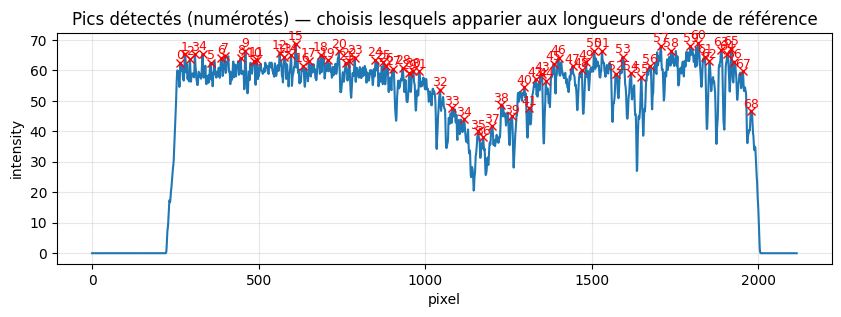

Raies candidates (Å) : [6402.25 6506.53 6532.88 6598.95 5852.49 6143.06 5944.83]
Suggestion automatique (pixels -> lambda):
[ 611 1708 1821]
[6402.25 6598.95 5944.83]

MODE D'EMPLOI :
 1) Exécute ce bloc pour obtenir la liste numérotée des pics (colonne 'peaks' au dessus).
 2) Pour un appariement sûr, choisis **manuellement** 3 à 6 pics visibles (note leur index pixel ci-dessus)
   et remplis pixels_peaks = np.array([...]) et peaks_lambda = np.array([...]) avec les lambda issues du poly (sect. 3.5.2).
 3) Décommente ensuite la ligne fit et exécute fit_and_plot(pixels_peaks, peaks_lambda) pour obtenir a,b et les résidus.



In [109]:
# --- Détection et aide au matching (colle dans ton notebook) ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# -------------- Remplace ces 2 lignes par ta variable réelle ----------------
# exemple : lamp_profile = avg_calib[0,:]  # ou extract_avg_spectrum si tu as déjà
lamp_profile = extract_avg_spectrum  # <<< ADAPT: nom exact dans ton notebook
pixels = np.arange(lamp_profile.size)

# léger lissage optionnel pour faciliter la détection
from scipy.ndimage import gaussian_filter1d
prof = gaussian_filter1d(lamp_profile.astype(float), sigma=1.0)

# détection automatique des pics (tune 'prominence' si tu détectes trop de bruits)
peaks, props = find_peaks(prof, prominence=0.08*np.max(prof), distance=8)
heights = props['prominences'] if 'prominences' in props else prof[peaks]

# afficher la liste des pics détectés (index en pixel)
print("Pics détectés (pixel, hauteur):")
for i,p in enumerate(peaks):
    print(i, p, prof[p])

# tracé interactif / visuel
plt.figure(figsize=(10,3))
plt.plot(pixels, prof, label='profil lampe (lissé)')
plt.plot(peaks, prof[peaks], 'x', color='red')
for i,p in enumerate(peaks):
    plt.text(p, prof[p]*1.02, str(i), color='red', fontsize=9, ha='center')
plt.xlabel('pixel')
plt.ylabel('intensity')
plt.title('Pics détectés (numérotés) — choisis lesquels apparier aux longueurs d\'onde de référence')
plt.grid(alpha=0.3)
plt.show()

# --- Liste de longueurs d'onde de référence (exemples) ---
# choisit la table haute ou basse résolution selon le réseau utilisé
lambda_ref_candidates = np.array([6402.25, 6506.53, 6532.88, 6598.95, 5852.49, 6143.06, 5944.83])
print("Raies candidates (Å) :", lambda_ref_candidates)

# ------------------ Option 1 : appariement manuel -------------------------
# Après avoir regardé le plot, remplis explicitement ces deux listes, par ex :
# pixels_peaks = np.array([  350,  1005,  2010 ])    # <-- A REMPLIR AVEC LES IDX VUS SUR LE PLOT
# peaks_lambda  = np.array([6402.25, 6506.53, 6598.95])  # <-- correspondances choisies

# ------------------ Option 2 : appariement semi-auto ----------------------
# (essaie d'associer automatiquement les N pics les plus hauts aux N raies choisies,
#  mais **vérifie visuellement** : si l'appariement automatique est mauvais, corrige le manuel)
def semi_auto_match(peaks, prof, lambda_choices, Nmatch=3):
    # prendre les Nmatch pics les plus proéminents
    prominences = prof[peaks]
    order = np.argsort(prominences)[::-1]
    chosen_peaks = peaks[order[:Nmatch]]
    # trier par pixel croissant
    chosen_peaks = np.sort(chosen_peaks)
    # choisir Nmatch raies espacées dans lambda_choices
    # ici on prend les Nmatch raies les plus représentatives (extrémité + milieu) par simplicité
    idxs = np.linspace(0, len(lambda_choices)-1, Nmatch, dtype=int)
    chosen_lams = lambda_choices[idxs]
    return chosen_peaks, chosen_lams

# exemple d'utilisation semi-auto (tu peux changer Nmatch)
peaks_suggestion, lams_suggestion = semi_auto_match(peaks, prof, lambda_ref_candidates, Nmatch=3)
print("Suggestion automatique (pixels -> lambda):")
print(peaks_suggestion)
print(lams_suggestion)

# ------------------ Fit affine si tu as les paires -------------------------
def fit_and_plot(pixels_peaks, peaks_lambda):
    # fit affine lambda = a * pixel + b
    A = np.vstack([pixels_peaks, np.ones_like(pixels_peaks)]).T
    coeffs, res, rank, s = np.linalg.lstsq(A, peaks_lambda, rcond=None)
    a, b = coeffs
    lambdas_fit = a * pixels_peaks + b
    resid = peaks_lambda - lambdas_fit
    rms = np.sqrt(np.mean(resid**2))
    print("fit: lambda = a*pixel + b  -> a = %.6e , b = %.6f" % (a, b))
    print("residus (Å):", resid)
    print("RMS residu (Å):", rms)
    # plot diagnostic
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    plt.plot(pixels, prof, label='lamp profile')
    plt.plot(pixels_peaks, prof[pixels_peaks], 'o', color='orange')
    for p,l in zip(pixels_peaks, peaks_lambda):
        plt.text(p, prof[p]*1.05, f'{l:.2f}', rotation=90, ha='center', color='orange')
    plt.title('Peaks utilisés et longueurs d\'onde associées')
    plt.xlabel('pixel')
    plt.subplot(1,2,2)
    plt.plot(pixels_peaks, peaks_lambda, 'o', label='ref points')
    xfull = np.linspace(0, pixels.max(), 200)
    plt.plot(xfull, a*xfull + b, '-', label='fit affine')
    plt.xlabel('pixel'); plt.ylabel('lambda (Å)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return a, b, rms

# ------------------ Mode d'emploi ------------------
print("\nMODE D'EMPLOI :\n 1) Exécute ce bloc pour obtenir la liste numérotée des pics (colonne 'peaks' au dessus).\n 2) Pour un appariement sûr, choisis **manuellement** 3 à 6 pics visibles (note leur index pixel ci-dessus)\n   et remplis pixels_peaks = np.array([...]) et peaks_lambda = np.array([...]) avec les lambda issues du poly (sect. 3.5.2).\n 3) Décommente ensuite la ligne fit et exécute fit_and_plot(pixels_peaks, peaks_lambda) pour obtenir a,b et les résidus.\n")

# Exemple d'usage semi-auto : (NE PAS LANCER tant que tu n'as pas validé l'appariement)
# pixels_peaks = peaks_suggestion
# peaks_lambda = lams_suggestion
# a,b,rms = fit_and_plot(pixels_peaks, peaks_lambda)

## *Question: Comment avez-vous choisis les valeurs caracteristiques pour faire la conversion en longueur d'onde?*

## *Réponse: (double-cliquez pour modifier le texte)*

Vu qu'on est essentiellement en train de modéliser une relation linéaire de type y = ax+b, il nous faudra au moins 2 points. Cependant, les arrays mis dans le DM nous demandent d'en choisir 3, et ceci dans le but d'être plus précis.

Afin de maximiser cette précision davantage, et en se basant toujours sur le fait que la relation est plutôt linéaire, il serait judicieux qu'on choisissent 3 points assez espacés l'un de l'autre, mais dont l'espacement et l'ordre suit un motif analogue à celui présent dans les spectres à haute résolution (vu que le réseau utilisé dans les données du DM est un réseau de 2400tr/mm) de la lampe d’étalonnage ArNe dans la section 3.5.2 du poly de TP.

En outre, il faut que les raies choisies soient également bien isolées afin qu'elles soient facilement identifiables sans qu'elles ne s'entremêlent.

Ensuite, on n'a qu'à mettre les valeurs correspondantes dans un même ordre dans les 2 arrays correspondantes.

Afin de vérifier, on pourrait même voir si les raies choisies obéissent tous à la même relation linéaire.

Enfin, les values liées de pics en pixels et en longueurs d'onde sont ultérieurement utilisées, en conjunction ave la fonction "affine",  par la fonction "curve_fit" fin de correctement établir la relation linéaire précedemment mentionnée

Il existe bien sûr des méthodes plus poussées constitant soit en l'augmentation de l'ordre du polynôme soit en l'utilisation des fits gaussiens, des régressions, des matrices de covarience et des résidus. Cependant, je ne sais pas les implémenter en Python et j'essaye de travailler sans l'aide de l'intelligence artificielle ; j'ai donc pu voir les méthodes plus avancées mais je me suis abstenu de les utiliser vu qu'il ne s'agissait pas de mon propre travail.


Il faudra également veiller à changer les longueurs d'onde présentes dans la section 3.5.2 du poly de TP en nm vu que le graphe suivant demande les "wavelengths in nm" et non en ångström

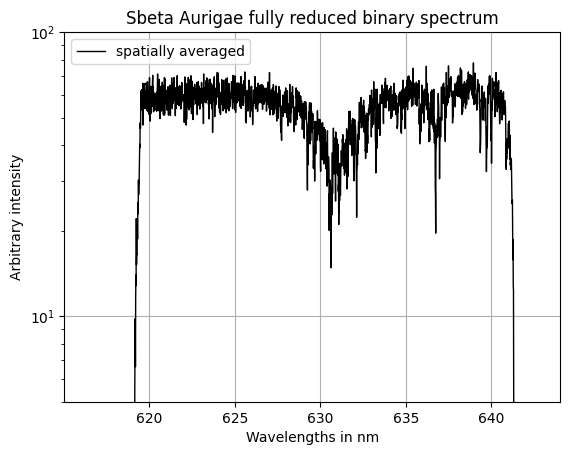

In [110]:
plt.figure(13)
plt.clf()
plt.plot(calib_wavelengths, extract_avg_spectrum, 'k-', lw=1, label='spatially averaged')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Wavelengths in nm')
plt.title('Sbeta Aurigae fully reduced binary spectrum')
plt.grid()
plt.legend(loc='best')
plt.ylim(5, 100) # A modifier
#plt.xlim(530,885)
plt.yscale('log')
#plt.show()